In [2]:
# import dependencies
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

from keras.applications.vgg16 import VGG16, preprocess_input
from keras.models import Model
from keras import backend as K

import tensorflow as tf

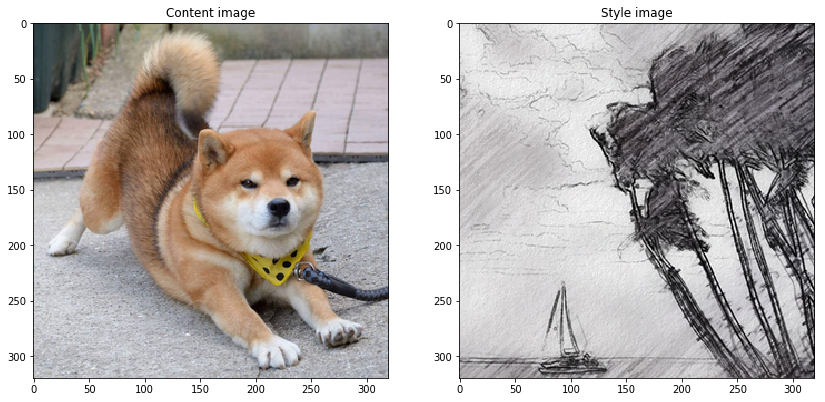

In [3]:
# reads in an image and scales it to be square
def imread(fname, size=(320, 320)):
    im = Image.open(fname)
    im = im.crop((0, 0, min(im.size), min(im.size)))
    im.thumbnail(size, Image.ANTIALIAS)
    return np.array(im)
    
# read in both the content image and style image
content_im = imread('shiba.jpg')
style_im = imread('sketch.jpg')

# plot the two images
plt.figure(figsize=(14, 14))
plt.subplot(1, 2, 1)
plt.title('Content image')
plt.imshow(content_im)

plt.subplot(1, 2, 2)
plt.title('Style image')
plt.imshow(style_im)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


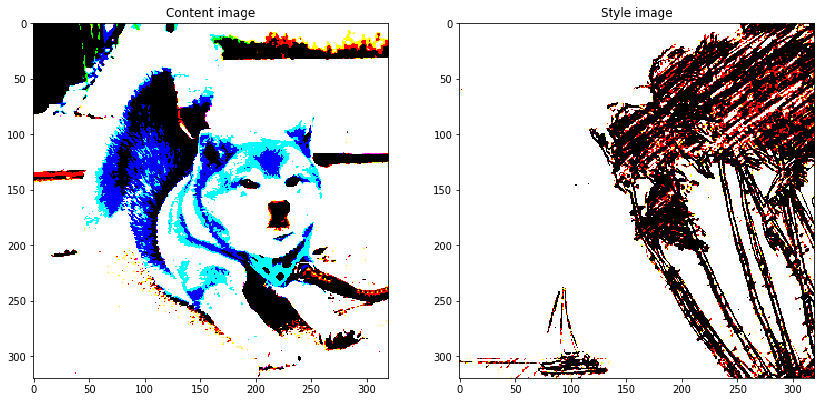

In [4]:
# preprocess images (i.e. center color values and convert RGB to BGR)
content_im = preprocess_input(content_im).reshape(1, 320, 320, 3)
style_im = preprocess_input(style_im).reshape(1, 320, 320, 3)

# plot images
plt.figure(figsize=(14, 14))
plt.subplot(1, 2, 1)
plt.title('Content image')
plt.imshow(content_im[0], cmap='gray')

plt.subplot(1, 2, 2)
plt.title('Style image')
plt.imshow(style_im[0], cmap='gray')
plt.show()

In [5]:
# Import VGG16 with pre-trained ImageNet weights.
model = VGG16(weights='imagenet', include_top=False)
print('VGG16 Architecture:')
model.summary()

VGG16 Architecture:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0

In [6]:
# calculates the gram-matrix of an output layer w.r.t. the feature activation
def gram(x):
    features = K.batch_flatten(K.permute_dimensions(x[0], (2, 0, 1)))
    return K.dot(features, K.transpose(features)) / (128**2)

# what layers to process?
layers = ['block1_conv1', 'block1_conv2',
          'block2_conv1', 'block2_conv2',
          'block3_conv1', 'block3_conv2', 'block3_conv3']
weights = [2, 2, 1, 1, 0.5, 0.5, 0.5]

# calculate output gram matrix of style image (to compare to the content image later)
grams = []
for name in layers:
    style_model = Model(inputs=model.input, outputs=model.get_layer(name).output)
    grams += [gram(style_model.predict(style_im))]

In [7]:
# hte loss function measures the style loss at multiple levels 
# (defined in layers). Also, compute the gradients w.r.t. the 
# input image of both losses and combines to single gradient.
total_loss, gradients = 0, None
for i, tup in enumerate(zip(layers, grams)):
    layer, style_gram = tup
    output = model.get_layer(layer).output
    
    # loss = mean squared error between desired style gram-matrices 
    # and gram-matrices of content image layer outputs.
    loss = K.mean(K.square(gram(output) - style_gram))
    total_loss += loss * weights[i]
    
    # computes gradient w.r.t the loss
    gradient = K.gradients(loss, model.input)[0] * weights[i]
    if gradients is not None:
        gradients += gradient 
    else:
        gradients = gradient
        
# normalize gradient to allow a single learning rate to be used
# regardless of the amount of to-be optimized layer outputs.
gradients = tf.clip_by_norm(gradients, 1)

# Create a function that returns the to-be maximized activation and gradients.
update = K.function([model.input], [total_loss, gradients])

In [8]:
# start with initial image
init = np.copy(content_im)

# Run gradient descent on the content image to minimize the 
# difference between features in the style image and the content image.
lr = 300
for i in range(200):
    loss, gradient = update([init])
    init -= lr * gradient
    
    print('iter {}: Current loss = {}'.format(i+1, loss))

iter 1: Current loss = 37793882112.0
iter 2: Current loss = 36121923584.0
iter 3: Current loss = 34452320256.0
iter 4: Current loss = 32790509568.0
iter 5: Current loss = 31142438912.0
iter 6: Current loss = 29513760768.0
iter 7: Current loss = 27909953536.0
iter 8: Current loss = 26336804864.0
iter 9: Current loss = 24800309248.0
iter 10: Current loss = 23305986048.0
iter 11: Current loss = 21858822144.0
iter 12: Current loss = 20463796224.0
iter 13: Current loss = 19125512192.0
iter 14: Current loss = 17847539712.0
iter 15: Current loss = 16632698880.0
iter 16: Current loss = 15483835392.0
iter 17: Current loss = 14402617344.0
iter 18: Current loss = 13389685760.0
iter 19: Current loss = 12445088768.0
iter 20: Current loss = 11568008192.0
iter 21: Current loss = 10756822016.0
iter 22: Current loss = 10009410560.0
iter 23: Current loss = 9323321344.0
iter 24: Current loss = 8695782400.0
iter 25: Current loss = 8123527168.0
iter 26: Current loss = 7603036160.0
iter 27: Current loss = 7

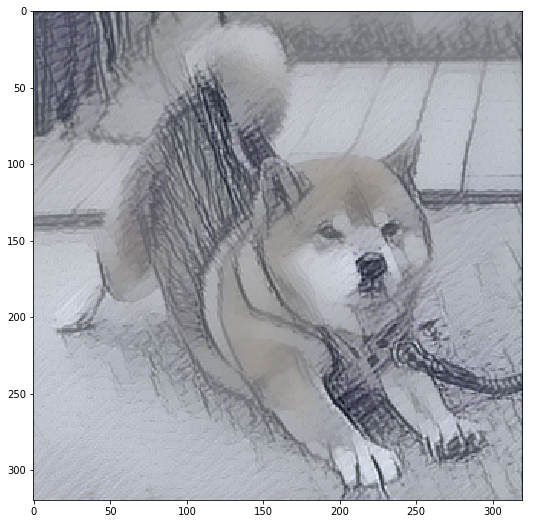

In [9]:
# normalize output to make sure that the image does not clip
init = init[0, :, :, ::-1]
init = init - np.min(init)
init = init / np.max(init)

# display image on screen
plt.figure(figsize=(9, 9))
plt.imshow(init, cmap='gray')
plt.show()

# save image to file
result_im = (init * 255).astype(np.uint8)
result_im = Image.fromarray(result_im)
result_im.save('output/output2_{}.jpg'.format('_'.join(layers)))